#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

ENCODING_DIM represents the size of the compressed version of input data.
<br>Doing some tests and also by thinking about it's meaning: if you use a bigger encoding dimension you will get a smaller mse value.
This because you have an higher dimension for data that means more precision for their representation. 
<br>To report some examples:
<br>ENCODING_DIM = 120 --> training mse: 0.00464 test mse: 0.00455
<br>ENCODING_DIM = 200 --> training mse: 0.00226 test mse: 0.00224
<br>ENCODING_DIM = 220 --> training mse: 0.00191 test mse: 0.00189

In [ ]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

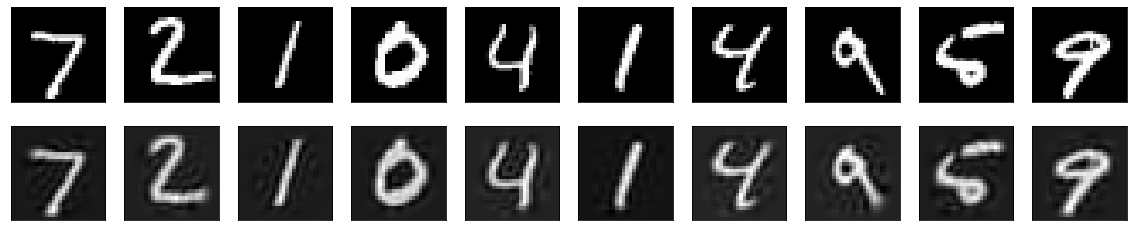

In [ ]:
plot_img(10, x_test, x_test_reco)

## Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 


check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 3s 22ms/step - loss: 0.0819 - val_loss: 0.0140
Epoch 2/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 8/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 2s 25ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00480


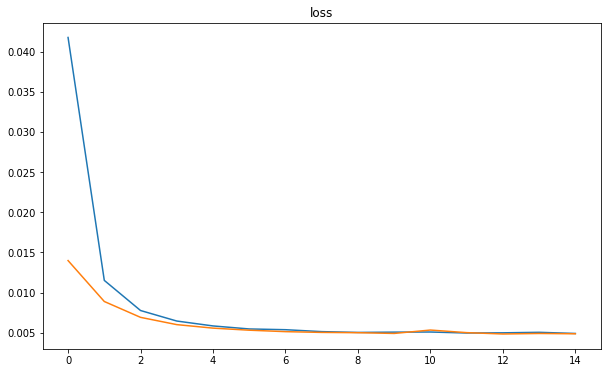

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

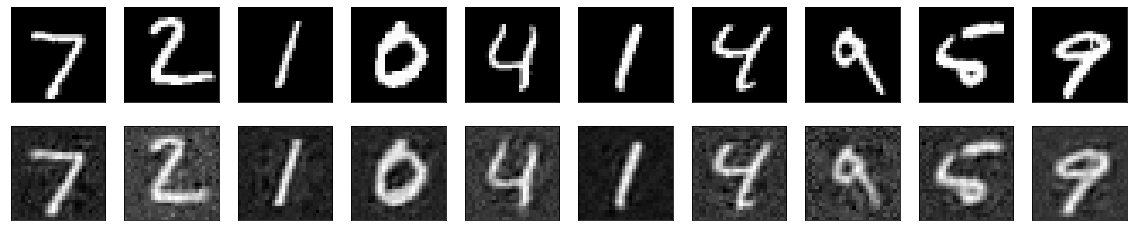

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


Let's see the results obtained:
<br>ENCODING_DIM = 120:
<br> - SVD:  test mse=0.00455
<br> - Linear Autoencoder: test mse: 0.00480

A shallow, undercomplete autoencoder which uses a linear activation function in the decoder and the mse as loss 
is basically what a SVD+PCA technique does. 
<br>In fact as we can see above the results that I obtained using SVD+PCA and the linear shallow autoencoder are quite the same, in fact.

## Exercise 5.3: Shallow non-linear autoencoders

replicate the code of Exercise 5.1 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.


The results obtained are:
<br>SVD:  test mse=0.00455
<br>Linear Autoencoder: test mse: 0.00480
<br>Shallow non-linear autoencoders:  test mse: 0.00424
<br><br>We can see that using Non linear functions we obtain slightly better results.
As we can see from the results above the non-linear autoencoder does not improve that much (It's just slightly better) with respect to the linear one and this could be related with this type of data.
<br><br>I decide to use the sigmoid activation in both the layers.
In the output layer because I want the output to be in the range [0,1] because values of the pixels are normalized. 
<br>In the hidden layer because after testing different activation functions (for example tanh, relu,....) it performs better.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0755 - val_loss: 0.0347
Epoch 2/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0311 - val_loss: 0.0220
Epoch 3/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0205 - val_loss: 0.0161
Epoch 4/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 5/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0121 - val_loss: 0.0105
Epoch 6/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 7/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 8/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 9/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 11/

313/313 - 0s - loss: 0.0042
test mse: 0.00424


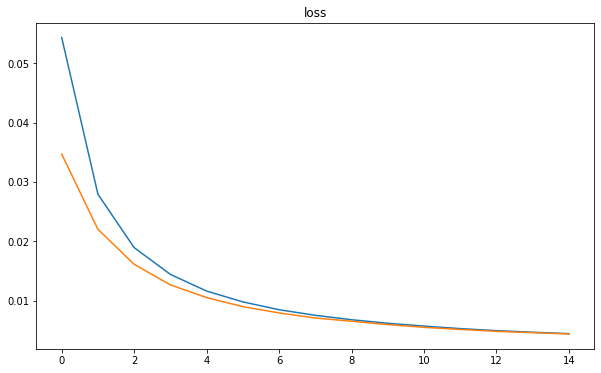

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(encoded)

decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               15480     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               15488     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 232,584
Trainable params: 232,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 20, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/20
98/98 [==============================] - 3s 22ms/step - loss: 0.0778 - val_loss: 0.0456
Epoch 2/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0360 - val_loss: 0.0281
Epoch 3/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0238 - val_loss: 0.0201
Epoch 4/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0184 - val_loss: 0.0165
Epoch 5/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 6/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 7/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 8/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 9/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 10/20
98/98 [==============================] - 2s 21ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 11/

313/313 - 0s - loss: 0.0065
test mse: 0.00645


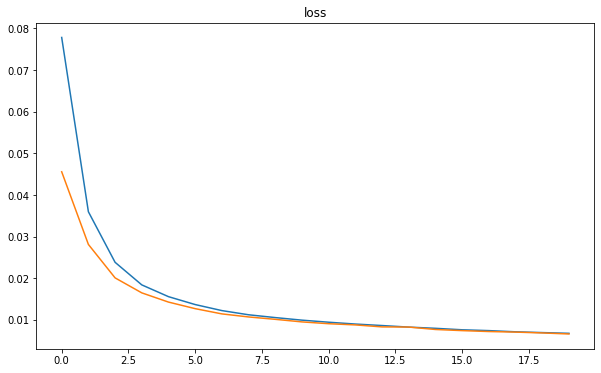

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

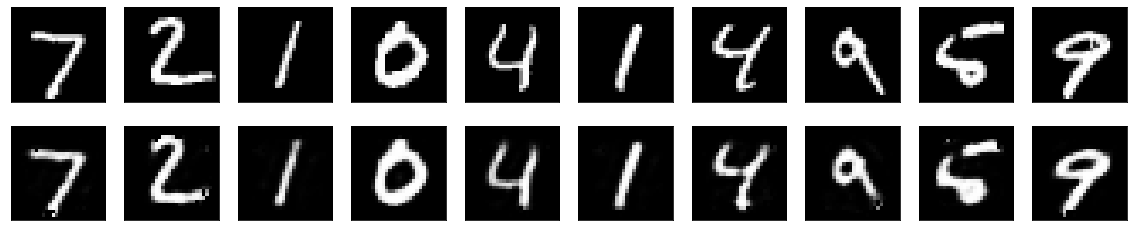

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.



I will report some results using different noise_factor values:
<br>noise factor: 0.3  ==> loss: 0.0074 test mse: 0.00736
<br>noise factor: 0.5  ==> loss: 0.0150 test mse: 0.01504
<br>noise factor: 0.7  ==> loss: 0.0375 test mse: 0.03749 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

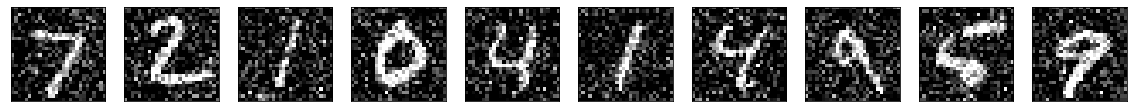

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
ENCODING_DIM=120
input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_38 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_39 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 20, batch_size= 256, shuffle=True, validation_data=(x_valid_noisy, x_valid))#[TO COMPLETE]

Epoch 1/20
196/196 [==============================] - 3s 11ms/step - loss: 0.0906 - val_loss: 0.0336
Epoch 2/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0301 - val_loss: 0.0215
Epoch 3/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0200 - val_loss: 0.0162
Epoch 4/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 5/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 6/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 7/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 8/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 9/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 10/20
196/196 [==============================] - 2s 11ms/step - loss: 0.0091 - val_lo

313/313 - 0s - loss: 0.0074
test mse: 0.00736


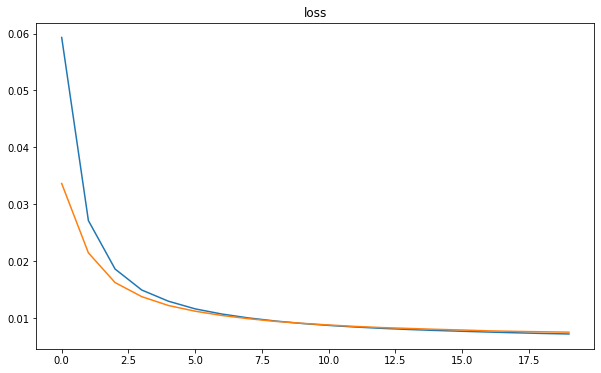

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

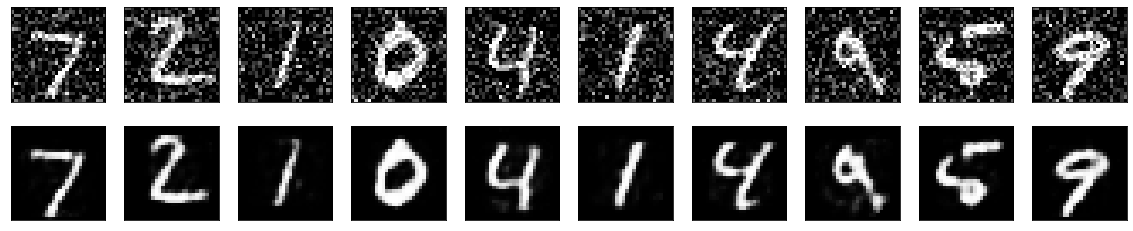

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 80ms/step - loss: 0.3045 - categorical_accuracy: 0.0230 - val_loss: 0.0890 - val_categorical_accuracy: 0.2262
Epoch 2/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0762 - categorical_accuracy: 0.3560 - val_loss: 0.0692 - val_categorical_accuracy: 0.3806
Epoch 3/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0670 - categorical_accuracy: 0.3951 - val_loss: 0.0501 - val_categorical_accuracy: 0.5295
Epoch 4/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0466 - categorical_accuracy: 0.5554 - val_loss: 0.0411 - val_categorical_accuracy: 0.5840
Epoch 5/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0392 - categorical_accuracy: 0.6114 - val_loss: 0.0351 - val_categorical_accuracy: 0.6242
Epoch 6/50
79/79 [==============================] - 6s 77ms/step - loss: 0.0332 - categorical_accuracy: 0.6388 - val_loss: 0.0310 - val_categorical_accuracy: 0.6365
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0108 - categorical_accuracy: 0.9360
categorical_accuracy: 93.60%


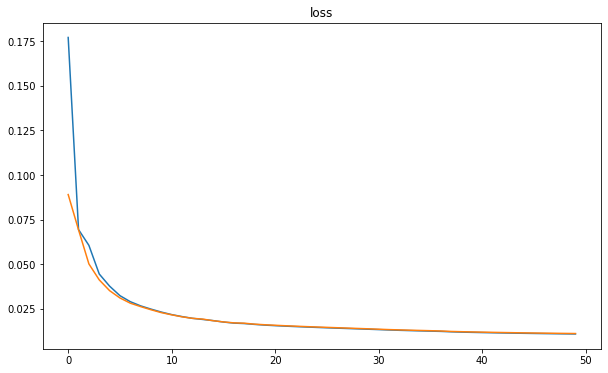

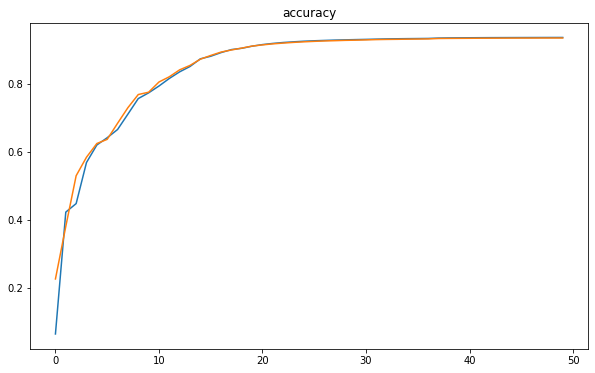

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> a are <oov> in all of him time but in <oov> the <oov> is <oov> a very <oov> film in just my <oov> <oov> <oov> <oov> as some it <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> as <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film if <oov> <oov> <oov> than to <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

**[ANSWER]** : The results obtained are:
<br>1- Autoencoder for sequences SimpleRNN: loss: 0.0108 - categorical_accuracy: 0.9360
<br>2- Autoencoder for sequences LSTM: loss: 1.8497e-04 - categorical_accuracy: 1.0000
<br>Results:
<br>As we can see from the results using non-linear activation functions (as in the second model) we get better performance compared with the one with only linear activation functions.

<br>Activation Functions:
<br>I choose the sigmoid function in the LSTM layer because we are deealing with a binary classification and also compared with other activation function (for example tanh) it gives me the best performance.
<br>For the output layer instead I choose to use the softmax function in order to get in output a value that represnt a probability.


In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(21, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 21)            10248     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           2200      
Total params: 12,448
Trainable params: 12,448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 96ms/step - loss: 0.0554 - categorical_accuracy: 0.0325 - val_loss: 0.0468 - val_categorical_accuracy: 0.4569
Epoch 2/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0436 - categorical_accuracy: 0.4715 - val_loss: 0.0375 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0369 - categorical_accuracy: 0.4708 - val_loss: 0.0368 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0361 - categorical_accuracy: 0.4721 - val_loss: 0.0360 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0352 - categorical_accuracy: 0.4700 - val_loss: 0.0344 - val_categorical_accuracy: 0.4614
Epoch 6/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0333 - categorical_accuracy: 0.4721 - val_loss: 0.0317 - val_categorical_accuracy: 0.4614
Epoch 7/50

40/40 - 1s - loss: 1.8478e-04 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


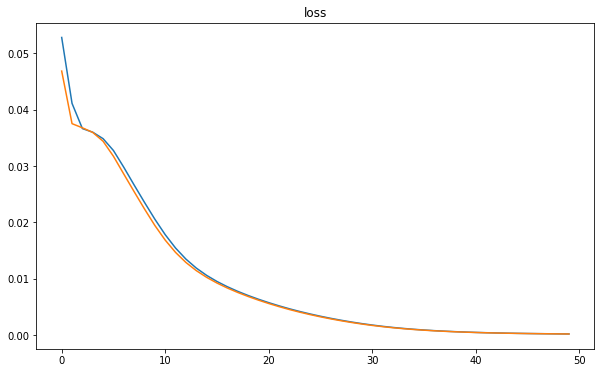

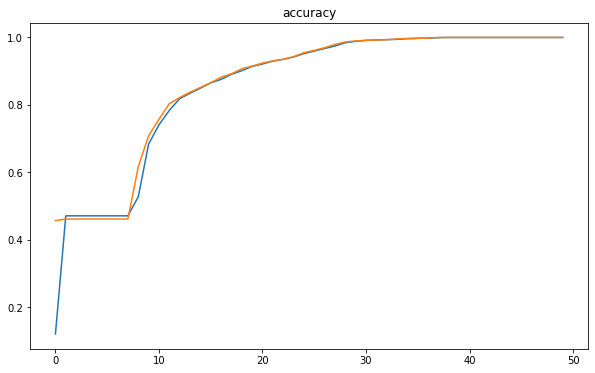

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
